In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bara

# Load CSV

In [2]:
dataframe = bara.load_csv("FED3V1_FP_test.csv")
# if you want to change the file loaded change the file name here

# Deinterleive the data

In [3]:
frames = bara.deinterleive(dataframe, "LedState", [1,2,4])
# Stores the split across a list of data frames
# each index is the LedState for each value in the key ([1,2,4] -> 415, 470, 560)

min_size = bara.smallest_size(frames)
frames = list(map(lambda df: bara.truncate(df,min_size), frames))
# Finds the smallest frame (led signal length) and shrinks to the same size

# Smooth Data

In [4]:
SIGNALS = ["Region0G", "Region2R", "Region1G", "Region3R"]
frames = list(
    map(
        lambda df: bara.smooth(df, SIGNALS, 20),
        frames,
    )
)
# Smooths the data
# Change the value 20 to change the size of the smoothing window

# Correct Signal

In [5]:
frames = list(
    map(lambda df: bara.correct_photobleach(df, "Timestamp", SIGNALS), frames)
)
# Corrects the data by the bi_exonential fit
frames = list(
    map(lambda df: bara.correct_reference(df, frames[0], SIGNALS), frames[1:])
)
# Corrects the data using the reference signal

# Split Fed Events

In [6]:
DURATION = 60
event_epochs = list(
    map(lambda df: bara.fed_events(df, "Timestamp", "Input0", DURATION), frames)
)
# If you want to change what Column is being used to signal a trigger, change "Input0"
# This splits arround a event on either side with half the time span

# Label Values
This is where we'll split the data into seperate variables

In [7]:
# Green Signals -------------------------
green_left_events = list(
    map(
        lambda df: pd.DataFrame({"Timestamp": df.Timestamp, "Signal": df.Region0G}),
        event_epochs[0],
    )
)

green_right_events = list(
    map(
        lambda df: pd.DataFrame({"Timestamp": df.Timestamp, "Signal": df.Region1G}),
        event_epochs[0],
    )
)

# Red Signals ---------------------------

red_left_events = list(
    map(
        lambda df: pd.DataFrame({"Timestamp": df.Timestamp, "Signal": df.Region2R}),
        event_epochs[1],
    )
)


red_right_events = list(
    map(
        lambda df: pd.DataFrame({"Timestamp": df.Timestamp, "Signal": df.Region3R}),
        event_epochs[1],
    )
)

# Normalize Data

In [8]:
signal_epochs = [
    green_left_events,
    green_right_events,
    red_left_events,
    red_right_events,
]

# signal_epochs = list(map(bara.normalize_df, signal_epochs))  # Uses DF/F
signal_epochs = list(map(bara.normalize_z,signal_epochs)) # Uses Z-Score
[
    green_left_events,
    green_right_events,
    red_left_events,
    red_right_events,
] = signal_epochs

# Uses a z_score to nomralize the data
# TODO (allow for custom baseline range)


# Collect Epochs into One DataFrame

In [9]:
green_left_df = pd.DataFrame([epoch.Signal.to_numpy() for epoch in green_left_events]).T

green_right_df = pd.DataFrame([epoch.Signal.to_numpy() for epoch in green_right_events]).T

red_left_df = pd.DataFrame([epoch.Signal.to_numpy() for epoch in red_left_events]).T

red_right_df = pd.DataFrame([epoch.Signal.to_numpy() for epoch in red_right_events]).T

time_stamps = np.linspace(0, DURATION, green_left_df.shape[0])

names = ["Green Left", "Green Right", "Red Left", "Red Right"]

data_frames = [green_left_df, green_right_df, red_left_df, red_right_df]

# Stiches the epoch data together into a signal dataframe
# Index\Epoch|_0_|_1_|_2-|_3_|...
#        0___| ~ | ~ | ~ | ~ |...
#        1___| ~ | ~ | ~ | ~ |...
#        2___| ~ | ~ | ~ | ~ |...
#        3___| ~ | ~ | ~ | ~ |...
#      ...___| ~ | ~ | ~ | ~ |...
#
# (the ~ is the data for that epoch

# Analysis

## SEM Data

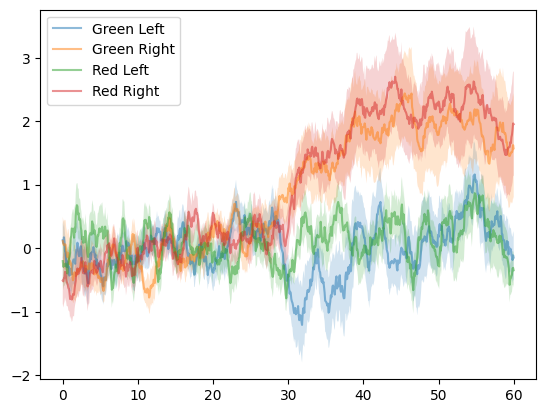

In [10]:
for name, frame in zip(names, data_frames):
    signal_data = bara.signal_sems(frame)
    plt.plot(time_stamps, signal_data.Mean, label=name, alpha=0.5)
    plt.fill_between(
        time_stamps,
        signal_data.Mean - signal_data.SEM,
        signal_data.Mean + signal_data.SEM,
        alpha=0.2,
    )
plt.legend()
plt.show()